In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
# CSVファイル読み込み
df = pd.read_csv('new_MyUberDrives.csv')
df.head(5)

,Unnamed: 0,CATEGORY*,MILES*,PURPOSE*,MONTH,START_HOUR_TIME
0,0,0,5.1,6,1.0,21.0
1,1,0,5.0,10,1.0,1.0
2,2,0,4.8,5,1.0,20.0
3,3,0,4.7,7,1.0,17.0
4,4,0,63.7,4,1.0,14.0


In [3]:
# Unnamed が邪魔なので削除する
drop_columns = ['Unnamed: 0']
df = df.drop(drop_columns, axis=1)

# データを訓練データ、テストデータに分割する
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size = 0.2)
# indexをリセットする
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(len(train_df),len(test_df))

924 231


In [4]:
# 特徴として使うデータとラベルとして使うデータに分ける
X_train = np.array(train_df.drop('CATEGORY*', axis=1).values).astype(np.float32)
y_train = np.array(train_df['CATEGORY*'].values).astype(np.float32)

X_test = np.array(test_df.drop('CATEGORY*', axis=1).values).astype(np.float32)
y_test = np.array(test_df['CATEGORY*'].values).astype(np.float32)

In [5]:
y_train = y_train.reshape(-1,1)
y_test =y_test.reshape(-1,1)

ロジスティック回帰でのモデル構築

In [6]:
# 入力層
X = tf.placeholder(tf.float32, shape=[None, 4], name="input")
t = tf.placeholder(tf.float32, shape=[None, 1])
# パラメータ1
W1 = tf.Variable(tf.truncated_normal([4,6]))
b1 = tf.Variable(tf.constant(0.1, shape=[1]))

# パラメータ2
stddev = np.sqrt(2.0 / 6)
W2 = tf.Variable(tf.truncated_normal([6,1], stddev=stddev))
b2 = tf.Variable(tf.constant(0.1, shape=[1]))

layer1 = tf.matmul(X,W1) + b1
layer2 = tf.matmul(layer1,W2) + b2

p = tf.nn.sigmoid(layer2,name="output")
# 損失関数
loss = tf.reduce_mean(tf.square(p - t))
# 学習アルゴリズム
optimizer = tf.train.GradientDescentOptimizer(0.01)
train_step = optimizer.minimize(loss)
# 精度
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 30
for i in range(5000):
    batch_mask = np.random.choice(X_train.shape[0], batch_size)
    x_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    sess.run(train_step,feed_dict={X: x_batch, t: y_batch})
    if i % 1000 == 0:
        train_acc, train_loss = sess.run([accuracy,loss], feed_dict={X: X_train, t: y_train})
        test_acc, test_loss = sess.run([accuracy,loss], feed_dict={X: X_test, t: y_test})
        print("[Train] step: %d, loss: %f, acc: %f, [Test] loss: %f, acc : %f" % (i, train_loss, train_acc,test_loss,test_acc))

[Train] step: 0, loss: 0.923744, acc: 0.073593, [Test] loss: 0.946625, acc : 0.051948
[Train] step: 1000, loss: 0.071444, acc: 0.928571, [Test] loss: 0.047619, acc : 0.952381
[Train] step: 2000, loss: 0.071434, acc: 0.928571, [Test] loss: 0.047619, acc : 0.952381
[Train] step: 3000, loss: 0.071432, acc: 0.928571, [Test] loss: 0.047619, acc : 0.952381
[Train] step: 4000, loss: 0.071431, acc: 0.928571, [Test] loss: 0.047619, acc : 0.952381


In [8]:
from xgboost import XGBRegressor
clf = XGBRegressor()

model = clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


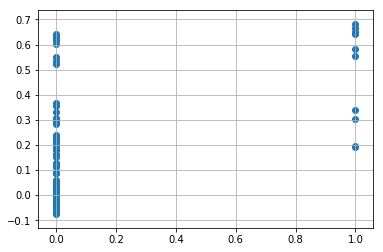

In [9]:
xg_pred = clf.predict(X_test)

plt.grid()
plt.scatter(y_test, xg_pred)
plt.show()

In [10]:
nn_pred = sess.run(p,feed_dict={X:X_test}).reshape(-1,)

平均二乗誤差

In [11]:
print('NN LogisticRegression mean square loss = {}'.format(np.mean(np.square(y_test - nn_pred))))
print('XGBoost mean square loss = {}'.format(np.mean(np.square(y_test - xg_pred))))

NN LogisticRegression mean square loss = 0.047617703676223755
XGBoost mean square loss = 0.07297752052545547


In [12]:
from sklearn.metrics import log_loss
nn_pred = sess.run(p,feed_dict={X:X_test}).reshape(-1,)
print('NN LogisticRegression log loss = {}'.format(log_loss(y_test,nn_pred)))
print('XGBoost log loss = {}'.format(log_loss(y_test,xg_pred)))

NN LogisticRegression log loss = 1.2728682604075339
XGBoost log loss = 0.10427648499862856


決定木のが優れているのがわかる。